In [36]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

In [38]:
from joblib import Parallel, delayed

In [39]:
loss = pd.read_csv('../results/agg_losses-all_25.csv', index_col=0,
                   header=0, usecols=[0,4],
                   names=['eid', 'losses'])

events = pd.read_csv('../results/aftershock_ruptures.csv', index_col=0)

In [40]:
eqs = events.join(loss).fillna(0)

In [41]:
mains = eqs.loc[eqs.aid == 0,:]
mains.index = mains.mainshock
afts = eqs.loc[eqs.aid != 0,:]

In [42]:
mains['aft_loss_sum'] = afts.groupby('mainshock').losses.sum()
mains['loss_ratio'] = mains.aft_loss_sum / mains.losses

/home/rstyron/src/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/rstyron/src/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


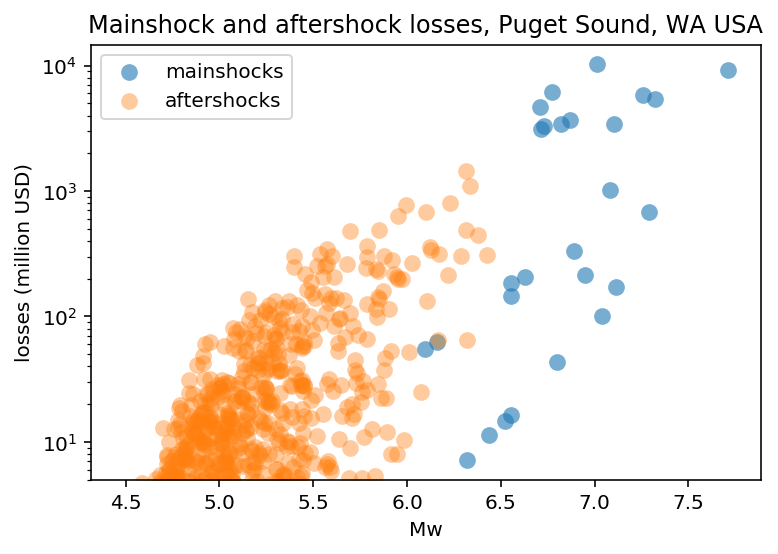

In [43]:
plt.figure()
plt.title('Mainshock and aftershock losses, Puget Sound, WA USA')
plt.scatter(mains.mag, mains.losses * 1e-6, 
            #c='purple', 
            lw=0, s=70,
            alpha=0.6,
            label='mainshocks')

plt.scatter(afts.mag, afts.losses * 1e-6, 
            #c='purple', 
            lw=0, s=70,
            alpha=0.4,
            label='aftershocks')

plt.gca().set_yscale('log')

plt.legend(loc='upper left')

plt.xlabel('Mw')
plt.ylabel('losses (million USD)')

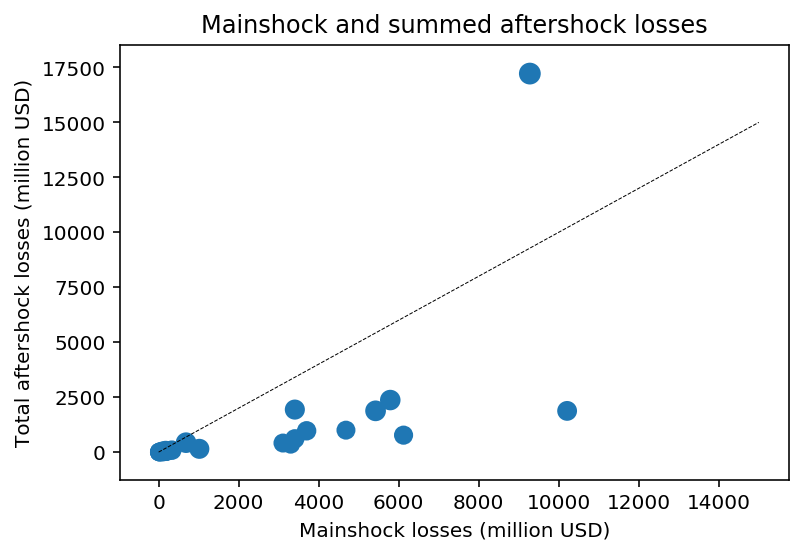

In [44]:
plt.figure()
plt.title('Mainshock and summed aftershock losses')

plt.plot([0,15000],[0,15000],
         'k--', lw=0.5)

plt.scatter(mains.losses * 1e-6, mains.aft_loss_sum * 1e-6,
            s=2 * (mains.mag**2),
            lw=0)

#plt.axis('equal')

plt.xlabel('Mainshock losses (million USD)')
plt.ylabel('Total aftershock losses (million USD)')

In [45]:
mains.losses.sum() / 15000

4112443.4646666665

In [46]:
afts.losses.sum() / 15000

2021686.8571453334

## Adding dates

In [10]:
eq_dates = pd.read_csv('../data/puget_lowland_mean_eq_ages.csv')

In [11]:
events.shape

(2317, 7)

In [12]:
eq_dates.tail()

,mainshock,year_bp
24,SWIF_EQ1,7698.158162
25,DDMFZ_EQ2,8085.274754
26,smf_E1,8631.464924
27,VasaParkEQ,11184.536872
28,SFZ_EQ_V,12532.215508


In [13]:
def year_bp_to_cal_year(year_bp):
    return 1950 - year_bp

In [14]:
eq_dates['cal_year'] = year_bp_to_cal_year(eq_dates['year_bp'])

In [15]:
eq_dates.tail()

,mainshock,year_bp,cal_year
24,SWIF_EQ1,7698.158162,-5748.158162
25,DDMFZ_EQ2,8085.274754,-6135.274754
26,smf_E1,8631.464924,-6681.464924
27,VasaParkEQ,11184.536872,-9234.536872
28,SFZ_EQ_V,12532.215508,-10582.215508


In [16]:
eq_dates['day'] = np.int_(np.round(eq_dates.cal_year * 365.25))

In [17]:
eq_dates.tail()

,mainshock,year_bp,cal_year,day
24,SWIF_EQ1,7698.158162,-5748.158162,-2099515
25,DDMFZ_EQ2,8085.274754,-6135.274754,-2240909
26,smf_E1,8631.464924,-6681.464924,-2440405
27,VasaParkEQ,11184.536872,-9234.536872,-3372915
28,SFZ_EQ_V,12532.215508,-10582.215508,-3865154


In [18]:
mains.head()

,aid,mainshock,mag,lon,lat,depth,day,losses,aft_loss_sum,loss_ratio
mainshock,,,,,,,,,,
Birch_Bay_Uplift,0,Birch_Bay_Uplift,6.888394,-122.973765,48.842685,9.899495,0.0,3.307010e+08,8.706782e+07,0.263283
smf_E3,0,smf_E3,7.040799,-123.205373,47.510866,10.125553,0.0,1.006280e+08,2.770474e+07,0.275318
crane_lake_eq_1,0,crane_lake_eq_1,6.822074,-122.475853,47.555052,10.336619,0.0,3.404400e+09,6.051673e+08,0.177760
SFZ_EQ_A,0,SFZ_EQ_A,6.711235,-122.486680,47.500006,9.899495,0.0,4.681910e+09,9.981885e+08,0.213201
kendall_EQB,0,kendall_EQB,6.522146,-122.001308,48.831629,9.899495,0.0,1.462590e+07,1.095072e+06,0.074872


In [19]:
for i, eq in eq_dates.iterrows():
    mains.loc[eq.mainshock, 'day'] = eq.day
    
mains['day'] = np.int_(mains.day)

/home/rstyron/src/miniconda3/lib/python3.5/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/rstyron/src/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [20]:
mains.head()

,aid,mainshock,mag,lon,lat,depth,day,losses,aft_loss_sum,loss_ratio
mainshock,,,,,,,,,,
Birch_Bay_Uplift,0.0,Birch_Bay_Uplift,6.888394,-122.973765,48.842685,9.899495,476577,3.307010e+08,8.706782e+07,0.263283
smf_E3,0.0,smf_E3,7.040799,-123.205373,47.510866,10.125553,311540,1.006280e+08,2.770474e+07,0.275318
crane_lake_eq_1,0.0,crane_lake_eq_1,6.822074,-122.475853,47.555052,10.336619,0,3.404400e+09,6.051673e+08,0.177760
SFZ_EQ_A,0.0,SFZ_EQ_A,6.711235,-122.486680,47.500006,9.899495,-1853374,4.681910e+09,9.981885e+08,0.213201
kendall_EQB,0.0,kendall_EQB,6.522146,-122.001308,48.831629,9.899495,-407554,1.462590e+07,1.095072e+06,0.074872


In [21]:
afts.head()

,aid,mainshock,mag,lon,lat,depth,day,losses
eid,,,,,,,,
1,1,Birch_Bay_Uplift,5.261875,-122.564718,48.765706,14.927014,0.0,7950980.0
2,2,Birch_Bay_Uplift,4.816055,-122.647121,48.658713,16.676181,0.0,253587.0
3,3,Birch_Bay_Uplift,5.340628,-122.354906,48.710668,8.041169,0.0,14192600.0
4,4,Birch_Bay_Uplift,4.554346,-122.895136,48.706962,16.752604,0.0,0.0
5,5,Birch_Bay_Uplift,5.304750,-122.830704,48.836331,13.457757,0.0,3297300.0


In [22]:
afts['cal_day'] = 0

for i, eq in afts.iterrows():
    afts.loc[i, 'cal_day'] = int( np.round(mains.loc[eq.mainshock, 'day'] + eq.day ))

/home/rstyron/src/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/rstyron/src/miniconda3/lib/python3.5/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [23]:
afts.head()

,aid,mainshock,mag,lon,lat,depth,day,losses,cal_day
eid,,,,,,,,,
1,1,Birch_Bay_Uplift,5.261875,-122.564718,48.765706,14.927014,0.0,7950980.0,476577
2,2,Birch_Bay_Uplift,4.816055,-122.647121,48.658713,16.676181,0.0,253587.0,476577
3,3,Birch_Bay_Uplift,5.340628,-122.354906,48.710668,8.041169,0.0,14192600.0,476577
4,4,Birch_Bay_Uplift,4.554346,-122.895136,48.706962,16.752604,0.0,0.0,476577
5,5,Birch_Bay_Uplift,5.304750,-122.830704,48.836331,13.457757,0.0,3297300.0,476577


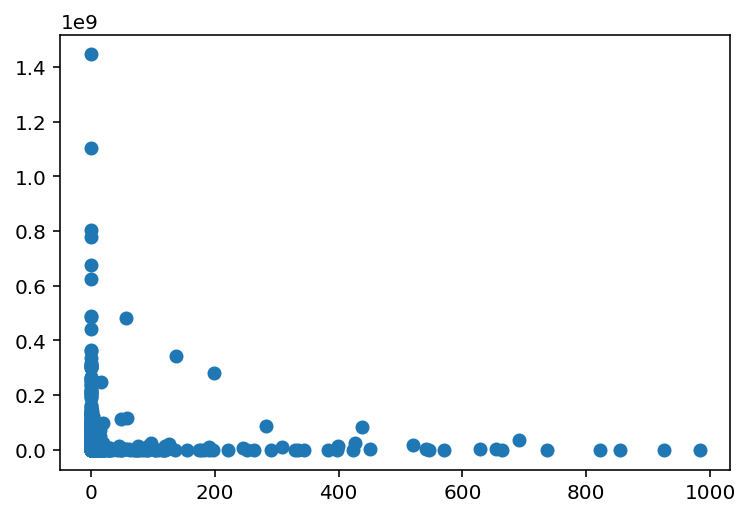

In [24]:
plt.scatter(afts.day, afts.losses)

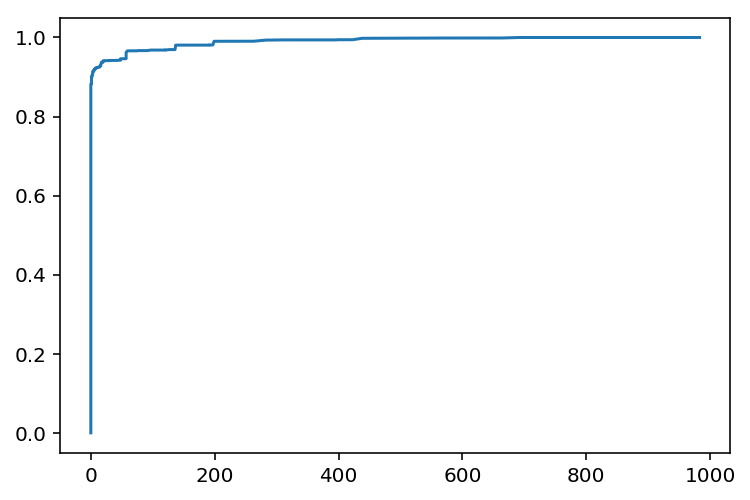

In [25]:
plt.plot(afts.sort_values('day').day, 
         np.cumsum(afts.sort_values('day').losses) / afts.losses.sum())

In [26]:
day_df = pd.DataFrame(index=np.arange(int(-11000 * 365.25), int(1700 * 365.25)),
                      columns=['mainshock_losses', 'aftershock_losses'])

day_df['mainshock_losses'] = 0.
day_df['aftershock_losses'] = 0.

In [27]:
for i, eq in mains.iterrows():
    day_df.loc[eq.day, 'mainshock_losses'] += eq.losses

In [28]:
for i, eq in afts.iterrows():
    day_df.loc[eq.cal_day, 'aftershock_losses'] += eq.losses

In [29]:
day_df['daily_losses'] = day_df.mainshock_losses + day_df.aftershock_losses

In [30]:
#day_df.drop(day_df.index[day_df.daily_losses == 0.], inplace=True)


#day_df.drop(day_df.index[pd.isnull(day_df.daily_losses)], inplace=True)
day_df.fillna(0, inplace=True)

In [31]:
day_df['main_cum_loss'] = np.cumsum(day_df.mainshock_losses)
day_df['aft_cum_loss'] = np.cumsum(day_df.aftershock_losses)
day_df['cum_loss'] = np.cumsum(day_df.daily_losses)

In [32]:
day_df.shape

(4638675, 6)

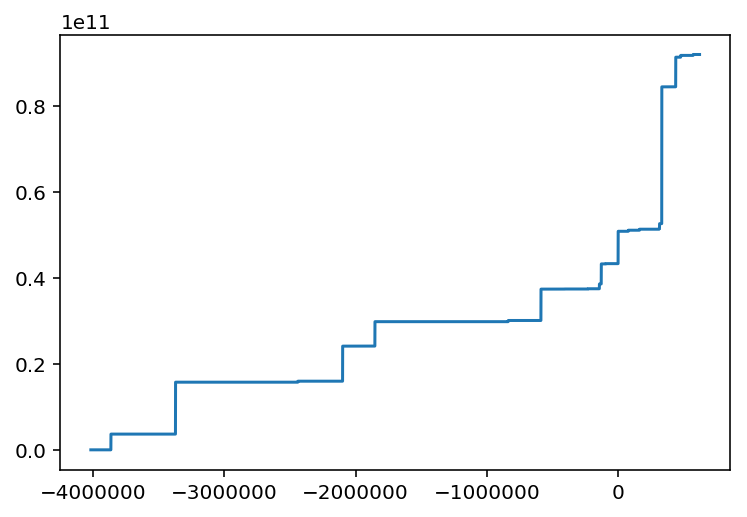

In [33]:
plt.plot(day_df.index, day_df.cum_loss)

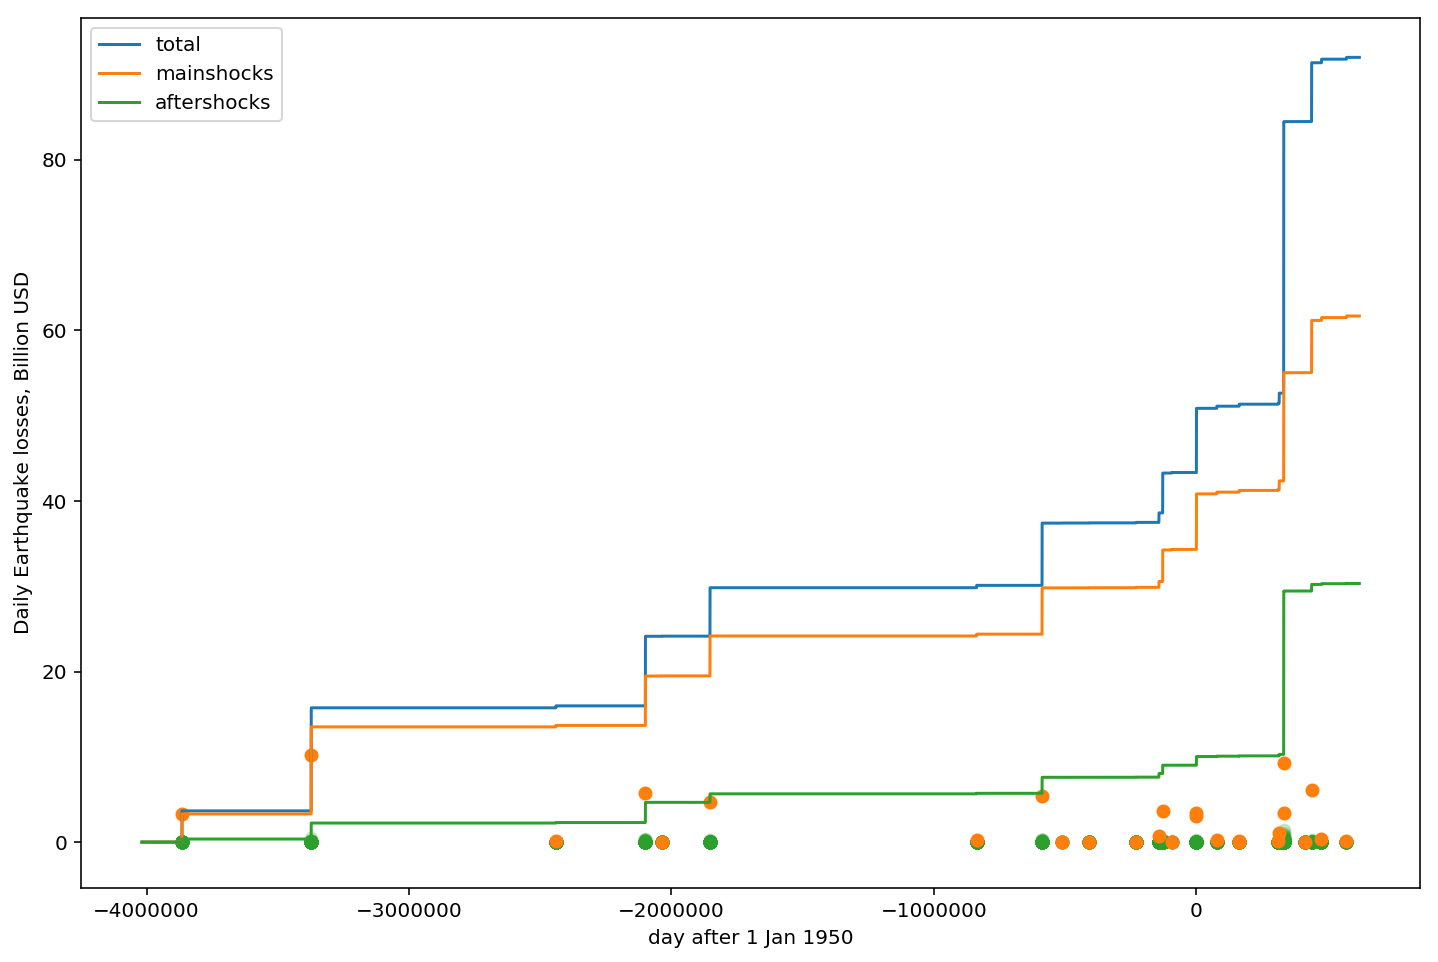

In [34]:
norm_amt = 1e9

plt.figure(figsize=(12,8))
plt.plot(day_df.index, day_df.cum_loss / norm_amt, 'C0', label='total')
plt.plot(day_df.index, day_df.main_cum_loss / norm_amt, 'C1', label='mainshocks')
plt.plot(day_df.index, day_df.aft_cum_loss / norm_amt, 'C2', label='aftershocks')

plt.legend(loc='upper left')

plt.scatter(afts.cal_day, afts.losses / norm_amt, c='C2', alpha=0.2)
plt.scatter(mains.day, mains.losses / norm_amt, c='C1')

plt.xlabel('day after 1 Jan 1950')
plt.ylabel('Daily Earthquake losses, Billion USD')

plt.show()

In [35]:
day_df['total_1_yr_sum'] = day_df.daily_losses.rolling(365).sum().fillna(0)
day_df['mainshock_1_yr_sum'] = day_df.mainshock_losses.rolling(int(365.25)).sum().fillna(0)
day_df['aftershock_1_yr_sum'] = day_df.aftershock_losses.rolling(365).sum().fillna(0)

day_df['total_5_yr_sum'] = day_df.daily_losses.rolling(int(5*365.25)).sum().fillna(0)
day_df['mainshock_5_yr_sum'] = day_df.mainshock_losses.rolling(int(5*365.25)).sum().fillna(0)
day_df['aftershock_5_yr_sum'] = day_df.aftershock_losses.rolling(int(5*365.25)).sum().fillna(0)

day_df['total_20_yr_sum'] = day_df.daily_losses.rolling(int(20*365.25)).sum().fillna(0)
day_df['mainshock_20_yr_sum'] = day_df.mainshock_losses.rolling(int(20*365.25)).sum().fillna(0)
day_df['aftershock_20_yr_sum'] = day_df.aftershock_losses.rolling(int(20*365.25)).sum().fillna(0)

day_df['total_50_yr_sum'] = day_df.daily_losses.rolling(int(50*365.25)).sum().fillna(0)
day_df['mainshock_50_yr_sum'] = day_df.mainshock_losses.rolling(int(50*365.25)).sum().fillna(0)
day_df['aftershock_50_yr_sum'] = day_df.aftershock_losses.rolling(int(50*365.25)).sum().fillna(0)


In [36]:
day_df.head()

,mainshock_losses,aftershock_losses,daily_losses,main_cum_loss,aft_cum_loss,cum_loss,total_1_yr_sum,mainshock_1_yr_sum,aftershock_1_yr_sum,total_5_yr_sum,mainshock_5_yr_sum,aftershock_5_yr_sum,total_20_yr_sum,mainshock_20_yr_sum,aftershock_20_yr_sum,total_50_yr_sum,mainshock_50_yr_sum,aftershock_50_yr_sum
-4017750,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-4017749,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-4017748,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-4017747,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-4017746,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


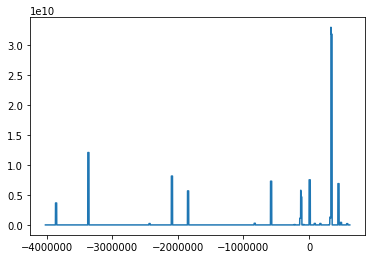

In [37]:
plt.plot(day_df.index, day_df.total_50_yr_sum)

In [38]:
day_df.mainshock_50_yr_sum.describe()

count    4.638675e+06
mean     2.428542e+08
std      1.322150e+09
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.370035e+10
Name: mainshock_50_yr_sum, dtype: float64

In [39]:
len(day_df.mainshock_50_yr_sum.unique())

32

In [40]:
def exceedence_probs(vals):
    
    exc_df = pd.DataFrame(index=np.arange(len(vals.unique())),
                          columns=['loss', 'exceedence_prob'])
        
    for i, u_val in enumerate(sorted(vals.unique())):
        exc_df.iloc[i] = (u_val, len(vals[vals >= u_val]) / len(vals))
        
    return exc_df
    

In [41]:
exc_p = exceedence_probs(day_df.mainshock_50_yr_sum)

In [42]:
exc_p

,loss,exceedence_prob
0,0,1
1,7.20027e+06,0.0903831
2,1.12697e+07,0.0864462
3,1.46259e+07,0.0825093
4,1.6307e+07,0.0785724
5,4.31451e+07,0.0746355
6,5.51177e+07,0.0706986
7,6.22043e+07,0.0706046
8,1.00628e+08,0.0666677
9,1.46208e+08,0.0658391


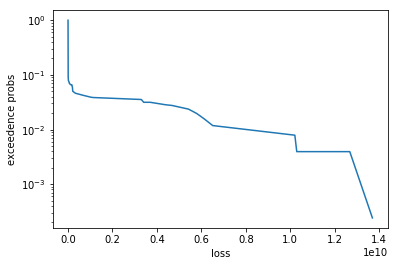

In [43]:
plt.plot(exc_p.loss, exc_p.exceedence_prob)
#plt.gca().set_xscale('log')
plt.gca().set_yscale('log')

plt.xlabel('loss')
plt.ylabel('exceedence probs')

plt.show()

In [44]:
eq_dates.head()

,mainshock,year_bp,cal_year,day
0,Utsalady_EQ2,384.780600,1565.219400,571696
1,Birch_Bay_Uplift,645.201985,1304.798015,476577
2,SFZ_EQE,748.643246,1201.356754,438796
3,kendall_EQC,820.859446,1129.140554,412419
4,SFZ_EQ_D,964.109045,985.890955,360097


In [45]:
del eq_dates['cal_year']

In [46]:
get_eq_days(eq_dates)

NameError: name 'get_eq_days' is not defined

In [47]:
def do_anal(main_df, aft_df, eq_dates, year_bp=True):
    
    print('eq days...')
    t0 = time.time()
    get_eq_days(eq_dates, year_bp=year_bp)
    t1 = time.time()
    print('done in {:0.1f}s \n'.format(t1-t0))
    
    print('mainshock days...')
    t0 = time.time()
    get_mainshock_days(main_df, eq_dates)
    t1 = time.time()
    print('done in {:0.1f}s \n'.format(t1-t0))
    
    print('aftershock days...')
    t0 = time.time()
    get_aftershock_days(aft_df, eq_dates)
    t1 = time.time()
    print('done in {:0.1f}s \n'.format(t1-t0))
    
    print('make day_df...')
    t0 = time.time()
    day_df = make_day_df()
    t1 = time.time()
    print('done in {:0.1f}s \n'.format(t1-t0))
    
    print('calc daily losses...')
    t0 = time.time()
    calc_daily_losses(day_df, main_df, aft_df)
    t1 = time.time()
    print('done in {:0.1f}s \n'.format(t1-t0))
    
    print('rolling losses...')
    t0 = time.time()
    for yr in (1, 50):
        rolling_losses(day_df, yrs=yr)
    t1 = time.time()
    print('done in {:0.1f}s \n'.format(t1-t0))
    
    return day_df

In [48]:
def year_bp_to_cal_year(year_bp):
    return 1950 - year_bp


def get_eq_days(eq_dates, year_bp=True):
    if year_bp == True:
        eq_dates['cal_year'] = year_bp_to_cal_year(eq_dates['year_bp'])

    eq_dates['day'] = np.int_(np.round(eq_dates.cal_year * 365.25))

    #return eq_dates


def get_mainshock_days(main_df, eq_dates):
    
    for i, eq in eq_dates.iterrows():
        main_df.loc[eq.mainshock, 'day'] = eq.day
    
    main_df['day'] = np.int_(main_df.day)

    #return main_df


def get_aftershock_days(aft_df, eq_dates):
    
    
    
    for i, eq in aft_df.iterrows():
        aft_df.loc[i, 'cal_day'] = int( np.round(mains.loc[eq.mainshock, 'day']
                                                 + eq.day) )
        
    #return aft_df


def make_day_df(yr_start=-11000, yr_end=1700):
    day_df = pd.DataFrame(index=np.arange(int(yr_start * 365.25), 
                                          int(yr_end * 365.25)),
                          columns=['mainshock_losses', 'aftershock_losses'])
    
    day_df['mainshock_losses'] = 0.
    day_df['aftershock_losses'] = 0.

    return day_df


def calc_daily_losses(day_df, main_df, aft_df):
    for i, eq in main_df.iterrows():
        day_df.loc[eq.day, 'mainshock_losses'] += eq.losses

    for i, eq in aft_df.iterrows():
        day_df.loc[eq.day, 'aftershock_losses'] += eq.losses

    day_df['daily_losses'] = day_df.mainshock_losses + day_df.aftershock_losses

    day_df.fillna(0, inplace=True)

    #return day_df


def rolling_losses(day_df, yrs=1,
                   cols=('daily_losses','mainshock_losses','aftershock_losses')):
    
    if 'daily_losses' in cols:
        day_df['total_{}_yr_sum'.format(yrs)] = day_df['daily_losses'].rolling(
                                             round(yrs*365.25)).sum().fillna(0)
    
    if 'mainshock_losses' in cols:
        day_df['mainshock_{}_yr_sum'.format(yrs)] = \
            day_df['mainshock_losses'].rolling(
                                             round(yrs*365.25)).sum().fillna(0)

    if 'aftershock_losses' in cols:
        day_df['aftershock_{}_yr_sum'.format(yrs)] = \
            day_df['aftershock_losses'].rolling(
                                             round(yrs*365.25)).sum().fillna(0)

    #return day_df

In [49]:
t0 = time.time()

dd = do_anal(mains, afts, eq_dates)

t1 = time.time()

print('done in {:.1f} s'.format(t1 - t0))

eq days...
done in 0.0s 

mainshock days...
done in 0.0s 


/home/rstyron/src/miniconda3/lib/python3.5/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s



aftershock days...
done in 79.5s 

make day_df...
done in 0.4s 

calc daily losses...
done in 1.0s 

rolling losses...
done in 1.0s 

done in 81.9 s


In [50]:
dd.tail()

,mainshock_losses,aftershock_losses,daily_losses,total_1_yr_sum,mainshock_1_yr_sum,aftershock_1_yr_sum,total_50_yr_sum,mainshock_50_yr_sum,aftershock_50_yr_sum
620920,0.0,0.0,0.0,0.00001,0.0,0.000006,0.00001,0.0,0.000006
620921,0.0,0.0,0.0,0.00001,0.0,0.000006,0.00001,0.0,0.000006
620922,0.0,0.0,0.0,0.00001,0.0,0.000006,0.00001,0.0,0.000006
620923,0.0,0.0,0.0,0.00001,0.0,0.000006,0.00001,0.0,0.000006
620924,0.0,0.0,0.0,0.00001,0.0,0.000006,0.00001,0.0,0.000006


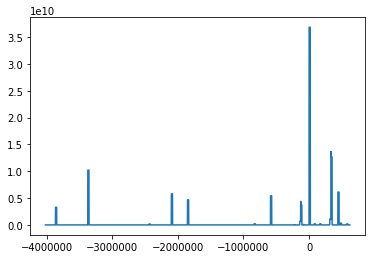

In [51]:
plt.plot(dd.index, dd.total_50_yr_sum)

In [52]:
dd.total_1_yr_sum.describe()

count    4.638675e+06
mean     7.240077e+06
std      3.675545e+08
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      3.665222e+10
Name: total_1_yr_sum, dtype: float64

In [53]:
eqs.losses.sum() / 13000

7077842.6790138455

In [54]:
mains

,aid,mainshock,mag,lon,lat,depth,day,losses,aft_loss_sum,loss_ratio
mainshock,,,,,,,,,,
Birch_Bay_Uplift,0.0,Birch_Bay_Uplift,6.888394,-122.973765,48.842685,9.899495,476577,3.307010e+08,8.706782e+07,0.263283
smf_E3,0.0,smf_E3,7.040799,-123.205373,47.510866,10.125553,311540,1.006280e+08,2.770474e+07,0.275318
crane_lake_eq_1,0.0,crane_lake_eq_1,6.822074,-122.475853,47.555052,10.336619,0,3.404400e+09,6.051673e+08,0.177760
SFZ_EQ_A,0.0,SFZ_EQ_A,6.711235,-122.486680,47.500006,9.899495,-1853374,4.681910e+09,9.981885e+08,0.213201
kendall_EQB,0.0,kendall_EQB,6.522146,-122.001308,48.831629,9.899495,-407554,1.462590e+07,1.095072e+06,0.074872
crane_lake_eq_2,0.0,crane_lake_eq_2,6.714995,-122.475853,47.555052,10.336619,0,3.107620e+09,4.119992e+08,0.132577
DDMFZ_EQ1,0.0,DDMFZ_EQ1,7.291294,-122.485690,48.423278,10.392305,-142897,6.856890e+08,4.285239e+08,0.624954
kendall_EQC,0.0,kendall_EQC,6.439627,-122.001308,48.831629,9.899495,412419,1.126970e+07,4.971432e+05,0.044113
frigid_EQ_1,0.0,frigid_EQ_1,6.318581,-123.259852,47.438094,9.969386,-512966,7.200270e+06,4.090842e+06,0.568151
